In [14]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

modelpath = r'F:\nllb-gos\hfacemodels'
modelname = 'facebook/nllb-200-distilled-1.3B' # 3.3B might be too big for my puny 3060 12GB (1.3B was too big for 1660ti) # note: there's distilled and non distilled models!
MODEL_SAVE_PATH = '../NLLB-GOS/models/nllb-nld-gos-distilled-1.3B-v0'

## 1. Exploring the data

In this section, I try to understand what is the training data that I have, and how suitable it is for fine-tuning a NLLB model.

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split

pd.options.display.max_colwidth = 80

# Load the Dutch and Gronings sentences
gos_sentences = pd.read_csv("../tatoeba/gos_sentences.tsv.bz2", sep="\t", header=None, names=["id", "language", "gos"])
nld_sentences = pd.read_csv("../tatoeba/nld_sentences.tsv.bz2", sep="\t", header=None, names=["id", "language", "nld"])

# Extract the links between the sentences
link_sentences = pd.read_csv("/tatoeba/links.tar.bz2", sep="\t", header=None, names=["origin", "translation"])

# sentences = gos_sentences['gos']
# words = [re.sub(r'[^\w\s]', '', s).lower().split() for s in sentences]
# allwords = [word for sublist in words for word in sublist]
# unique_words = set(allwords)
# print("Aantal unieke woorden:", len(unique_words))

# Merge the datasets to find translation pairs
df_parallel = link_sentences.merge(nld_sentences, left_on="origin", right_on="id").merge(gos_sentences, left_on="translation", right_on="id")[["origin", "translation", "nld", "gos"]]
if df_parallel.isnull().any().any(): print('null entries found')
# print(len(df_parallel))

# Optionally, save to a CSV file
# df_parallel.to_csv("../tatoeba/tatoeba_pairs.csv", index=False)

# First split into train (98%) and temp (2%)
df_train, df_temp = train_test_split(df_parallel, test_size=0.02, random_state=9358)
# Then split the temp (2%) into validation (1%) and test (1%)
df_validate, df_test = train_test_split(df_temp, test_size=0.5, random_state=9358)

del df_temp, link_sentences, nld_sentences, gos_sentences
display(df_test.sample(3))

,origin,translation,nld,gos
2804,4244587,8703516,Goedkoper kan niet.,Goudkooperder kin nait.
9235,12827609,12827608,Kunnen we dan niet voorlezen op scholen?,Kinnen we din nait veurlezen op schoulen?
7114,8673577,8722553,Mijn schoonzus is Nederlands.,Mien schoonzuster is Nederlaands.


In [ ]:
# import requests

# url = "https://api.tatoeba.org/unstable/sentences"
# params = {
#     "lang": "gos",
#     "q": "noam", #search in tatoeba database here
#     "include_unapproved": "yes"
# }

# response = requests.get(url, params=params)

# # Check if the request was successful
# if response.status_code == 200:
#     data = response.json()
#     print('success, found',len(data['data']),'\n')
#     #print(data)  # Print the response JSON
# else:
#     print(f"Request failed with code: {response.status_code}")

# for i in data['data']:
#     print(i['text'])

## 2. How well does the data fit into a NLLB tokenizer?

In [2]:
from transformers import NllbTokenizer
import re

tokenizer = NllbTokenizer.from_pretrained(modelname, cache_dir=modelpath)

texts_with_unk = [text for text in df_parallel.gos if tokenizer.unk_token_id in tokenizer(text).input_ids]
if len(texts_with_unk)>0.001*len(df_parallel): print('more than 0.1% <unk> tokens found!')

c:\Users\tbran\.conda\envs\NLLB\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\tbran\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


NameError: name 'df_parallel' is not defined

In [ ]:
# def word_tokenize(text):
#     # naive word tokenizer for languages with English-like orthography (spaces)
#     return re.findall('(\w+|[^\w\s])', text)

# smpl = df_train#.sample(2000, random_state=1)

# smpl['nld_toks'] = smpl.nld.apply(tokenizer.tokenize)
# smpl['gos_toks'] = smpl.gos.apply(tokenizer.tokenize)

# smpl['nld_words'] = smpl.nld.apply(word_tokenize)
# smpl['gos_words'] = smpl.gos.apply(word_tokenize)

# display(smpl.sample(4)[['gos', 'gos_words', 'gos_toks', 'nld', 'nld_words', 'nld_toks']])
# stats = smpl[['nld_toks', 'gos_toks', 'nld_words', 'gos_words']].map(len).describe()
# # display(stats)
# print('tokens per word nld:\t', stats.nld_toks['mean'] / stats.nld_words['mean'])
# print('tokens per word gos:\t', stats.gos_toks['mean'] / stats.gos_words['mean'])

For Russian and Tyvan, the NLLB tokenizer produces 2.3 and 1.8 tokens per word, which means that the translation quality of fine-tuned NLLB may be decent even without vocabulary extension.

The NLLB model was pretrained on normalized texts, so some unknown tokens might just be punctuation unfamiliar to the NLLB tokenizer. If we reproduce the normalization, this problem should be fixed.

In [ ]:
# # this code is adapted from the Stopes repo of the NLLB team
# # https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

# import sys
# import typing as tp
# import unicodedata
# from sacremoses import MosesPunctNormalizer


# mpn = MosesPunctNormalizer(lang="en")
# mpn.substitutions = [
#     (re.compile(r), sub) for r, sub in mpn.substitutions
# ]

# def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
#     non_printable_map = {
#         ord(c): replace_by
#         for c in (chr(i) for i in range(sys.maxunicode + 1))
#         # same as \p{C} in perl
#         # see https://www.unicode.org/reports/tr44/#General_Category_Values
#         if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
#     }

#     def replace_non_printing_char(line) -> str:
#         return line.translate(non_printable_map)

#     return replace_non_printing_char

# replace_nonprint = get_non_printing_char_replacer(" ")

# def preproc(text):
#     clean = mpn.normalize(text)
#     clean = replace_nonprint(clean)
#     # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
#     clean = unicodedata.normalize("NFKC", clean)
#     return clean

# texts_with_unk_normed = [text for text in texts_with_unk if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
# print(len(texts_with_unk_normed))

### 3 (optional). Expanding the vocabulary

# 4. Adding a new language tag to the tokenizer and model

In [4]:
from transformers import AutoModelForSeq2SeqLM, NllbTokenizer
from gc import collect
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# we need transformers<=4.33 for this to work.

def fix_tokenizer(tokenizer, new_lang='gos_Latn'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

def cleanup():
    """Try to free GPU memory"""
    collect()
    torch.cuda.empty_cache()

tokenizer = NllbTokenizer.from_pretrained(modelname, cache_dir=modelpath)
print(tokenizer.convert_ids_to_tokens([256202, 256203]))

fix_tokenizer(tokenizer)
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'tyv_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'gos_Latn', '<mask>'])) # [256202, 256203, 256204]

C:\Users\tbran\AppData\Local\Temp\ipykernel_18120\1938893810.py:4: UserWarning: Failed to initialize NumPy: DLL load failed while importing _multiarray_umath: Kan opgegeven module niet vinden. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:84.)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
C:\Users\tbran\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


['zul_Latn', '<mask>']
['zul_Latn', 'gos_Latn', '<mask>']
[256202, 256203, 256204]


In [ ]:
# either first load model (to wherever) and then move to gpu
# model = AutoModelForSeq2SeqLM.from_pretrained(modelname, cache_dir=modelpath)
# model = model.to(device)
# print(next(model.parameters()).device)

In [5]:
cleanup()
# Load model directly into VRAM???
model = AutoModelForSeq2SeqLM.from_pretrained(modelname, cache_dir=modelpath, device_map={"": "cuda:0"})# or "auto"

c:\Users\tbran\.conda\envs\NLLB\Lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\tbran\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
added_token_id = tokenizer.convert_tokens_to_ids('gos_Latn')
#similar_lang_id = tokenizer.convert_tokens_to_ids('deu_Latn')
#similar_lang_id = tokenizer.convert_tokens_to_ids('nld_Latn')
#similar_lang_id = tokenizer.convert_tokens_to_ids('eng_Latn')
#similar_lang_id = tokenizer.convert_tokens_to_ids('fry_Latn')
#similar_lang_id = tokenizer.convert_tokens_to_ids('nds_Latn')
similar_lang_id = tokenizer.convert_tokens_to_ids('nld_Latn')
print(added_token_id, similar_lang_id)

model.resize_token_embeddings(len(tokenizer))

# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


256203 256127


Embedding(256205, 1024)

# 5. Preparing the training loop

In [12]:
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer

model.cuda();

optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

batch_size = 10  # 8 is fine, 12 maybe??
max_length = 100 #no idea if it should be shorter
warmup_steps = 100
training_steps = 900

losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]

def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample([('nld', 'nld_Latn'), ('gos', 'gos_Latn')], 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))
# (['Wie binnen Tom zien dochters.'], ['Wij zijn Toms dochters.'], 'gos_Latn', 'nld_Latn')

(['U erft niks.'], ['Joe aarven niks.'], 'nld_Latn', 'gos_Latn')


## 6. The training loop

In [15]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 100 == 0 and i > 0:
        print(i, "mean loss of last 100 steps:\t", np.mean(losses[-100:]))
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

 11%|█         | 100/900 [02:48<23:15,  1.74s/it]

100 mean loss of last 100 steps:	 2.561516564488411


 22%|██▏       | 200/900 [05:56<17:59,  1.54s/it]  

200 mean loss of last 100 steps:	 1.256977396607399


 33%|███▎      | 300/900 [08:53<15:56,  1.59s/it]  

300 mean loss of last 100 steps:	 0.9805910208821297


 44%|████▍     | 400/900 [11:54<12:56,  1.55s/it]  

400 mean loss of last 100 steps:	 0.8696372683346272


 56%|█████▌    | 500/900 [14:57<09:57,  1.49s/it]

500 mean loss of last 100 steps:	 0.7834780897200108


 67%|██████▋   | 600/900 [17:58<08:28,  1.69s/it]

600 mean loss of last 100 steps:	 0.6424149797856807


 78%|███████▊  | 700/900 [21:08<06:00,  1.80s/it]

700 mean loss of last 100 steps:	 0.6472415623068809


 89%|████████▉ | 800/900 [24:20<03:17,  1.98s/it]

800 mean loss of last 100 steps:	 0.557715124040842


100%|██████████| 900/900 [27:31<00:00,  1.84s/it]


In [16]:
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

('../NLLB-GOS/models/nllb-nld-gos-distilled-1.3B-v0\\tokenizer_config.json',
 '../NLLB-GOS/models/nllb-nld-gos-distilled-1.3B-v0\\special_tokens_map.json',
 '../NLLB-GOS/models/nllb-nld-gos-distilled-1.3B-v0\\sentencepiece.bpe.model',
 '../NLLB-GOS/models/nllb-nld-gos-distilled-1.3B-v0\\added_tokens.json')

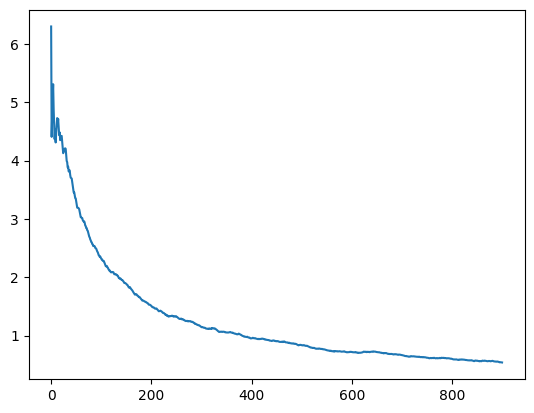

In [17]:
pd.Series(losses).ewm(100).mean().plot();

In [18]:
def translate(text, src_lang='nld_Latn', tgt_lang='gos_Latn', a=16, b=1.5, max_input_length=700, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [19]:
s = 'Ik heb niet het geduld om boeken te lezen, maar ik vind verhalen wel leuk.'
langA = 'nld_Latn'
langB = 'gos_Latn'

print(s)
t = translate(s, langA, langB)
print(t)
t_back = translate(t, langB, langA)
print(t_back)

Ik heb niet het geduld om boeken te lezen, maar ik vind verhalen wel leuk.
['Ik heb nait t geduld bouken te lezen, mor k vin verhalen apmoal leuk.']
['Ik heb het geduld boeken te lezen, maar ik vind de verhalen allemaal leuk.']


In [37]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_train)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['Tom zien bruier Tim is n tjoender dij baang veur knienen is.']
['Toms broer Tim is een tovenaar die bang is voor konijnen.']
['Toms broer Tim is een tandarts die bang is voor kneeuwpijn.']


In [ ]:
!ls -alsh $MODEL_SAVE_PATH

## 7. Using the model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [ ]:
# df_parallel = pd.read_csv('/gd/MyDrive/datasets/nlp/tyvan/for_translator.csv')
# df_parallel.dropna(subset=['ru', 'tyv'], inplace=True)
# df_train, df_devtest = train_test_split(df_parallel, test_size=1000, random_state=1)
# df_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=1)

In [2]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [ ]:
model_load_name = '../NLLB-GOS/models/nllb-nld-gos-v6'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
# fix_tokenizer(tokenizer)

In [4]:
def fix_tokenizer(tokenizer, new_lang='gos_Latn'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

fix_tokenizer(tokenizer)

In [5]:
def translate(text, src_lang='nld_Latn', tgt_lang='eng_Latn', a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [ ]:
t = 'De vertalingen zijn niet perfect, maar er gaat al best veel goed.' #"мөңгүн үр чыткаш карарар"
print(translate(t, 'nld_Latn', 'gos_Latn'))
#t_translated translate(t, 'nld_Latn', 'gos_Latn')
# ['серебро от времени чернеет']

In [ ]:
translate(t, 'nld_Latn', 'gos_Latn', do_sample=True, num_beams=2, temperature=1.5)

In [8]:
def batched_translate(texts, batch_size=16, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [ ]:
rus_translated = batched_translate(df_dev.tyv, src_lang='tyv_Cyrl', tgt_lang='rus_Cyrl')

In [ ]:
df_dev['rus_translated'] = [translate(t, 'tyv_Cyrl', 'rus_Cyrl')[0] for t in tqdm(df_dev.tyv)]
df_dev['tyv_translated'] = [translate(t, 'rus_Cyrl', 'tyv_Cyrl')[0] for t in tqdm(df_dev.ru)]

In [ ]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [ ]:
!pip install editdistance

In [ ]:
import editdistance

def ed_similarity(text1, text2):
    return max(0, 1 - editdistance.eval(text1, text2) / min(len(text1), len(text2)))

print(ed_similarity('кот', 'собака'))
print(ed_similarity('кот', 'кит'))

In [ ]:
pd.Series([ed_similarity(row.ru, row.rus_translated) for row in df_dev.itertuples()]).describe()

In [ ]:
pd.Series([ed_similarity(row.tyv, row.tyv_translated) for row in df_dev.itertuples()]).describe()

In [ ]:
df_dev.index.name = "row_id"

In [ ]:
df_dev.to_csv(model_load_name + "/dev_set_translated.tsv", sep="\t")

In [ ]:
print(bleu_calc.corpus_score(df_dev['rus_translated2'].tolist(), [df_dev['ru'].tolist()]))
print(chrf_calc.corpus_score(df_dev['rus_translated2'].tolist(), [df_dev['ru'].tolist()]))
print(bleu_calc.corpus_score(df_dev['tyv_translated2'].tolist(), [df_dev['tyv'].tolist()]))
print(chrf_calc.corpus_score(df_dev['tyv_translated2'].tolist(), [df_dev['tyv'].tolist()]))

In [ ]:
df_dev['rus2eng'] = [translate(t, 'tyv_Cyrl', 'eng_Latn')[0] for t in tqdm(df_dev.tyv)]
df_dev['tyv2eng'] = [translate(t, 'rus_Cyrl', 'eng_Latn')[0] for t in tqdm(df_dev.ru)]

Results with num_beams=1:
```
V1
BLEU = 23.21 51.2/29.1/18.0/11.8 (BP = 0.978 ratio = 0.978 hyp_len = 2273 ref_len = 2324)
chrF2++ = 47.88
BLEU = 22.03 51.5/29.7/17.9/10.4 (BP = 0.952 ratio = 0.953 hyp_len = 2260 ref_len = 2371)
chrF2++ = 49.37
V2
BLEU = 24.08 50.9/29.5/19.1/12.3 (BP = 0.988 ratio = 0.988 hyp_len = 2297 ref_len = 2324)
chrF2++ = 48.96
BLEU = 22.50 50.5/28.5/17.7/11.1 (BP = 0.974 ratio = 0.974 hyp_len = 2310 ref_len = 2371)
chrF2++ = 48.85
V3
BLEU = 22.25 49.8/27.8/17.2/11.0 (BP = 0.983 ratio = 0.983 hyp_len = 2284 ref_len = 2324)
chrF2++ = 47.89
BLEU = 25.28 52.2/31.2/20.0/13.1 (BP = 0.989 ratio = 0.989 hyp_len = 2346 ref_len = 2371)
chrF2++ = 51.87
````

Results with 4 beams:
```
V1
BLEU = 24.14 52.5/30.4/18.9/12.1 (BP = 0.981 ratio = 0.981 hyp_len = 2281 ref_len = 2324)
chrF2++ = 49.49
BLEU = 23.41 52.1/31.0/18.9/11.3 (BP = 0.966 ratio = 0.967 hyp_len = 2292 ref_len = 2371)
chrF2++ = 50.89
V2
BLEU = 25.18 52.4/31.3/20.4/13.3 (BP = 0.976 ratio = 0.976 hyp_len = 2269 ref_len = 2324)
chrF2++ = 49.85
BLEU = 23.22 51.6/29.4/18.3/11.6 (BP = 0.975 ratio = 0.975 hyp_len = 2312 ref_len = 2371)
chrF2++ = 49.87
V3
BLEU = 23.06 51.1/29.1/18.1/11.5 (BP = 0.978 ratio = 0.978 hyp_len = 2273 ref_len = 2324)
chrF2++ = 48.56
BLEU = 26.12 53.4/32.5/21.0/13.6 (BP = 0.985 ratio = 0.985 hyp_len = 2336 ref_len = 2371)
chrF2++ = 52.60
```

Which means:
* For all directions and models, beam search improves the results
* Longer training builds up quality for Tyvan, but decreases it for Russian.

```
                                  | tyv->rus | rus->tyv
Model v1 (no vocabulary update):  |
    no beam search                |   23.21  |  22.03
    num_beams = 4                 |   24.14  |  23.41
Model v2 (with vocabulary update):|
    no beam search                |   24.08  |  22.50
    num_beams = 4                 |   25.18  |  23.22
```

## Publishing the model to HF

In [ ]:
!huggingface-cli login

In [ ]:
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig

In [ ]:
def fix_tokenizer(tokenizer, new_lang='tyv_Cyrl'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [ ]:
model_load_name = '/gd/MyDrive/models/nllb-rus-tyv-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name)
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

In [ ]:
upload_repo = "slone/nllb-rus-tyv-v1"
tokenizer.push_to_hub(upload_repo)
model.push_to_hub(upload_repo)

In [ ]:
model_load_name = '/gd/MyDrive/models/nllb-rus-tyv-v2-extvoc'
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
cfg = AutoConfig.from_pretrained(model_load_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name + "/pytorch_model_60k.bin", config=cfg)

In [ ]:
upload_repo = "slone/nllb-rus-tyv-v2-extvoc"
tokenizer.push_to_hub(upload_repo)
model.push_to_hub(upload_repo)

In [ ]:
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'tyv_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'tyv_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

In [ ]:
MODEL_URL = 'slone/nllb-rus-tyv-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_URL)
tokenizer = NllbTokenizer.from_pretrained(MODEL_URL, force_download=True)
fix_tokenizer(tokenizer)

In [ ]:
def translate(
    text,
    model,
    tokenizer,
    src_lang='rus_Cyrl',
    tgt_lang='tyv_Cyrl',
    max_length='auto',
    num_beams=4,
    no_repeat_ngram_size=4,
    n_out=None,
    **kwargs
):
    tokenizer.src_lang = src_lang
    encoded = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    if max_length == 'auto':
        max_length = int(32 + 2.0 * encoded.input_ids.shape[1])
    model.eval()
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
        max_length=max_length,
        num_beams=num_beams,
        no_repeat_ngram_size=no_repeat_ngram_size,
        num_return_sequences=n_out or 1,
        **kwargs
    )
    out = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    if isinstance(text, str) and n_out is None:
        return out[0]
    return out